# What is AB testing?

In A/B testing we show the enhanced/modified version of the product to a sample of customers - the experimental group and the existing version of the product to another sample of customers - the control group. We track, the difference in product performance in experimental versus the control group, if any, to identify the effect of this new version of the product on its performance. In other words, the goal is to track the metric during the test period and find out if there is a difference in the performance of the product and what type of difference is it.

- Advantages 

    -  Feedback about results can be collected very quickly
    -  Results are unbiased as, users are unaware.

- Disadvantages 

    -  Might lead to incorrect results, if parameters are not chosen carefully.

# Steps for AB testing 

- Designing our experiment
- Collecting and preparing the data
- Testing the hypothesis
- Visualising the results
- Drawing conclusions

## Problem 

An advertising company has developed a new ad to have users engage with their questionnaire. The company has shown the new ad to some users and a dummy ad to others and wants their data analyst team to interpret the results. Does the new ad generate more responses to their questionnaire? Is it statistically significant? Is the company justified in using the new ad?  

A/B testing is common in the business world and is a way to compare two versions of something to figure out which performs better. Figuring out which ad users prefer is a real life business problem that would be expected to know how to solve as a business data analyst. 

## Dataset 

Dataset is found on kaggle from an advertising company. https://www.kaggle.com/osuolaleemmanuel/ad-ab-testing.

Detailed eda has been performed in EDA.ipynb.

## AB TESTING

If we want to test 
-  whether there is a statistically significant difference between the control and experimental groups’ metrics that are in the form of averages (e.g. average purchase amount) or proportions (e.g. Click Through Rate), 
-  metric follows Normal distribution, or 
-  when the sample size is larger than 30 such that you can use Central Limit Theorem (CLT) to state that the sampling distributions of Control and Experimental groups are asymptotically Normal, you can use 2-tailed Z-test.

We formulate a hypothesis for 2-tailed z-test.

- H_0: p_exposed = p_control
- H_a: p_exposed <> p_control

Where p_control and and p_exposed stand for conversion rate of old and new ad.

- H_0 is the null hypothesis that states there is no statistically significant difference between the control and experimental groups response.
- H_a is the alternate hypothesis that states there is statistically significant difference between control and experimental groups.

Power is the the probability of correctly identifying the effect when there is indeed an effect. Usually the power of the test(1-beta) is chosen as 80%.

Significance level, also denoted as alpha or α: is the probability of rejecting a null hypothesis when it is true. By rejecting a true null hypothesis, we falsely claim there is an effect when there is no actual effect. Thus, it is also called the probability of False Positive. We use alpha = 0.05%. That means the confidence level is 95%.

The minimum change that the business would like to detect in this test. Choice of this parameter depends on the nature of the test and business constraints.We would like to detect at least a 0.1% increase in clicking yes button in order for it to be worth the effort.

###### Collect and Prepare data

In [6]:
import pandas as pd
ads=pd.read_csv("AdSmartABdata - AdSmartABdata.csv")
#show the first 5 rows of the data
ads.head() 

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [7]:
#extract the exposed group
exposed_data = ads[ads['experiment']=='exposed']
exposed_data.shape

(4006, 9)

In [8]:
#extract the control group
control_data = ads[ads['experiment']=='control']
control_data.shape

(4071, 9)

In [13]:
import statsmodels.stats.api as sms
import numpy as np

In [16]:
#check if we can use a sample of our dataset for the experiments.
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower
np.random.seed(1)
effect = 0.1
alpha = 0.05
power = 0.8

# perform power analysis 
analysis = TTestIndPower()
result = analysis.solve_power(effect, power = power,nobs1= None, ratio = 1.0, alpha = alpha)
print('Sample Size: %.3f' % round(result))
df_control = control_data.sample(n=1571,replace=True)
X_control_sampled = df_control[df_control['yes']==1].count()[0]
print("Number of control data rows :", X_control_sampled)
df_exposed = exposed_data.sample(n=1571,replace=True)
X_exposed_sampled=df_exposed[df_exposed['yes']==1].count()[0]
print("Number of exposed data rows :",X_exposed_sampled)
p_control_sampled =X_control_sampled/result
p_exposed_sampled =X_exposed_sampled/result
p_pooled_success_sampled = (X_control_sampled + X_exposed_sampled)/(1571*2)
#print(p_pooled_success_sampled )
pooled_variance_sampled = p_pooled_success_sampled*(1-p_pooled_success_sampled)* (1/1571 + 1/1571)
#print(pooled_variance_sampled)
test_stat_sampled = np.abs(p_control_sampled-p_exposed_sampled)/np.sqrt(pooled_variance_sampled)
#print(test_stat_sampled)
one_side_sampled = 1 - stats.norm(loc = 0, scale = 1).cdf(test_stat_sampled)
#print(one_side_sampled)
p_value_sampled = one_side_sampled * 2
print("p-value for sampled data :",p_value_sampled)



Sample Size: 1571.000
Number of control data rows : 98
Number of exposed data rows : 110
p-value for sampled data : 0.38913620811158944


Since the sampling at a specific value(here 1) gives us less than 100 rows for the control group. And per industry practices, a minimum of 100 rows should be used in the tests. Also different seed values, gives varied p-value results, due to which such tests can not be used conclusively to arrive at any conclusion. 

Hence we have decided not to use a sample of the dataset, rather all the rows will be used in our test.

###### Test the hypothesis

Continuing our test with the entire dataset.

In [17]:
#number of yes clicks for control group 
X_control = control_data[control_data['yes']==1].count()[0]
X_control

264

In [18]:
#Total number of impressions for control group 
N_control = control_data.count()[0]
N_control

4071

In [19]:
p_control = X_control/N_control
p_control

0.06484893146647015

In [20]:
#number of yes clicks for exposed group 
X_exposed = exposed_data[exposed_data['yes']==1].count()[0]
X_exposed

308

In [21]:
#Total number of impressions for exposed group 
N_exposed = exposed_data.count()[0]
N_exposed

4006

In [22]:
p_exposed = X_exposed/N_exposed 
p_exposed

0.07688467299051423

Since we are testing for the difference in these probabilities, we need to obtain an estimate for the pooled probability of success and an estimate for pooled variance

In [23]:
#estimate for the pooled probability of success
p_pooled_success = (X_control + X_exposed)/(N_control + N_exposed)
p_pooled_success

0.07081837315835088

In [24]:
#estimate for pooled variance
pooled_variance = p_pooled_success*(1-p_pooled_success)* (1/N_control + 1/N_exposed)
pooled_variance

3.259001761135153e-05

In [25]:
#test statsitics
import numpy as np
test_stat = np.abs(p_control-p_exposed)/np.sqrt(pooled_variance)
test_stat

2.108290999972843

In [26]:
#two sided test and using symmetry property of Normal distibution so we multiple with 2
import scipy.stats as stats
one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(test_stat)
one_side

0.01750291298416229

In [27]:
p_value = one_side * 2
p_value

0.03500582596832458

In [28]:
# Confidence Interval
p_diff = p_control-p_exposed
p_diff 

-0.012035741524044075

In [29]:
significance = 0.05

In [30]:
confidence = 1 - significance
confidence

0.95

In [31]:
#z critical value using the standard normal distribution
Z_crit = stats.norm(loc = 0, scale = 1).ppf(confidence + significance / 2)
Z_crit

1.959963984540054

In [32]:
#margin error
se = np.sqrt(pooled_variance)
se

0.005708766732960065

In [33]:
confint = p_diff + np.array([-1, 1]) * Z_crit * se
confint

array([-0.02322472, -0.00084676])

In [34]:
print("Test Statistics stat: ", test_stat)
print("Z-critical: ", Z_crit)
print("P_value: ", p_value)
print("Confidence Interval of 2 sample Z-test for proportions: ", confint)

Test Statistics stat:  2.108290999972843
Z-critical:  1.959963984540054
P_value:  0.03500582596832458
Confidence Interval of 2 sample Z-test for proportions:  [-0.02322472 -0.00084676]


###### Compare the values with stats library

In [44]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint, confint_proportions_2indep

In [45]:
successes = [X_control, X_exposed]
successes

[264, 308]

In [46]:
nobs = [N_control,N_exposed]
nobs

[4071, 4006]

In [47]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(z_stat, pval)

(-2.108290999972843, 0.035005825968324515)

In [48]:
from statsmodels.stats.proportion import confint_proportions_2indep
lower, upper =  confint_proportions_2indep(X_control,
                                           N_control, 
                                           X_exposed,
                                           N_exposed, 
                                           method=None,
                                           compare='diff',
                                           alpha=0.05, 
                                           correction=True)
print(lower,upper)

-0.023274457406590773 -0.0008398362969589592


In [49]:
print("Test Statistics stat: ", z_stat)
print("P_value: ", pval)
print("Confidence Interval of 2 sample Z-test for proportions: ", (lower,upper))

Test Statistics stat:  -2.108290999972843
P_value:  0.035005825968324515
Confidence Interval of 2 sample Z-test for proportions:  (-0.023274457406590773, -0.0008398362969589592)


###### Visualise the results 

In [50]:
#https://cosmiccoding.com.au/tutorials/ab_tests
rate_control, rate_exposed = X_control/N_control, X_exposed/N_exposed 
print(rate_control, rate_exposed)

0.06484893146647015 0.07688467299051423


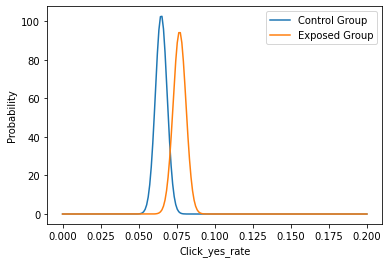

In [51]:
import matplotlib.pyplot as plt
std_control = np.sqrt(rate_control*(1-rate_control)/N_control)
std_exposed = np.sqrt(rate_exposed*(1-rate_exposed)/N_exposed)
click_yes_rate = np.linspace(0, 0.20, 200)

prob_control = stats.norm(rate_control, std_control).pdf(click_yes_rate)
prob_exposed = stats.norm(rate_exposed, std_exposed).pdf(click_yes_rate)
# Make the bar plots.
plt.plot(click_yes_rate, prob_control, label="Control Group")
plt.plot(click_yes_rate, prob_exposed, label="Exposed Group")
plt.xlabel("Click_yes_rate"); 
plt.ylabel("Probability");
plt.legend()

This is showing, given the data we collected, the probability that the actual click_yes_rate for A and B has a certain value.

###### Conclude the results

- Since our p-value=0.03500582596832458 is less than our α=0.05 threshold, we can reject the Null hypothesis Hₒ, which means that our new ad did perform statistically significantly different than our old one. 

- Since 0 is not included in the confidence interval, the change is statiscally significant. 